 # Explain ResNet50 ImageNet classification using Statistical Fault Localisation and RISE - PyTorch


<img src="images/explainer_blueprint.png" alt="My Image" width="30%"/>

### In depth tutorial with visualisations



In [399]:
import os
import shutil
import filecmp

In [400]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms.functional import resize, InterpolationMode
from ipywidgets import interact, IntSlider, fixed
from tensorflow.keras.applications.resnet50 import preprocess_input
from IPython.display import display
from PIL import Image
from keras.preprocessing import image
# Assuming utils, evaluation, and explanations modules are custom and present in your project
from utils import *
import shap
import math
import json
from torch.nn.functional import softmax, conv2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [401]:
cudnn.benchmark = True
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()
for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
model = nn.DataParallel(model)

Top 1 class: tiger cat, Probability: 45.77%
Top 2 class: tabby, Probability: 39.74%
Top 3 class: Egyptian cat, Probability: 14.15%


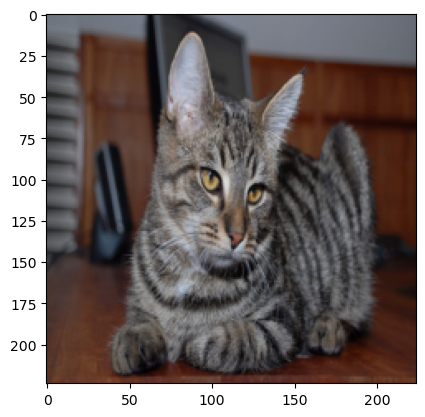

In [402]:
'''
    This function is used to read the image and convert it to a tensor, 
    Preprocess the image by resizing it to 224x224,
    Normalizing the image with the mean and standard deviation of the ImageNet dataset,
    Add a batch dimension to the image tensor
    Output -> [1, 3, 224, 224]  [B, C, H, W]
    
'''
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])

# Here we load the class names for ImageNet dataset, so we can map the class index to the class name
def get_class_name(c):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[c].split(',')[0].split()[1:])

# This function is used to display the image tensor as an image using matplotlib,

def tensor_imshow(inp, title=None, **kwargs):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Mean and std for ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)

img_path = r'C:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\causal-explainer\data_demo\ILSVRC2012_val_00000796.jpeg'
img = read_tensor(img_path)
N = 100 # Number of samples to explain the prediction
s = 8
p1 = 0.1
t = 0 # Prediction Index

with torch.no_grad():
    output = model(img)
    top_probabilities, top_classes = torch.topk(output, k=3, dim=1)
    top_pred_class = top_classes[0][t].item() #Second index represent the prediction, 0,1,2 -> Top 1,2,3 prediction
    top_pred_class_name = get_class_name(top_pred_class) # Get the class name that prediction
    target_class = top_pred_class # The class we want to explain, in this case the top prediction

for zx in range(3):
    class_name = get_class_name(top_classes[0][zx].item())
    percentage = top_probabilities[0][zx].item() * 100
    print(f'Top {zx+1} class: {class_name}, Probability: {percentage:.2f}%')

tensor_imshow(img[0])

# 

In [403]:
class SFL:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = torch.tensor(input_size, device='cuda')
        self.device = torch.device('cuda')

    def generate_support_masks(self, N, s, p1, input_size=(224, 224)):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Calculate cell size and up size
        cell_size = torch.ceil(torch.tensor(self.input_size).float() / s)
        up_size = ((s + 1) * cell_size).int()

        # Create random grid
        grid = (torch.rand(N, s, s) < p1).float().to(self.device)

        # Initialize support masks
        support_masks = torch.empty(N, 1, *input_size, device=self.device)

        for i in range(N):
            # Random shifts
            x = torch.randint(0, int(cell_size[0]), (1,))
            y = torch.randint(0, int(cell_size[1]), (1,))

            # Resize grid
            resized_grid = resize(grid[i].unsqueeze(0), tuple(up_size.int().tolist()), 
                                  interpolation=InterpolationMode.BILINEAR)

            # Crop and assign to support masks
            support_masks[i, 0] = resized_grid[0, 
                                               x:x + input_size[0], 
                                               y:y + input_size[1]]
        return support_masks

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]
    
    @torch.no_grad()
    def generate_mutants_batch(self, img_tensor, N, s, p1, target_class, batch_size=50):
    
        _, channels, height, width = img_tensor.shape
        self.masks = torch.empty((N, 1, height, width), device=self.device)
        sampled_tensor = torch.empty((N, channels, height, width), device=self.device)
        confidence_scores = []
        
        for start_idx in tqdm(range(0, N, batch_size), total=(N + batch_size - 1) // batch_size, ascii="░▒█"):
            end_idx = min(start_idx + batch_size, N)
            batch_size_current = end_idx - start_idx
            
            batch_masks = torch.empty((batch_size_current, 1, height, width), device=self.device)
            found_flags = torch.zeros(batch_size_current, dtype=torch.bool, device=self.device)
            
            while not found_flags.all():
                # Generate masks for all unfound samples in the batch
                unfound_indices = torch.where(~found_flags)[0]
                pass_indices = unfound_indices[unfound_indices % 2 == 0]
                fail_indices = unfound_indices[unfound_indices % 2 == 1]
                
                if len(pass_indices) > 0:
                    batch_masks[pass_indices] = self.generate_support_masks(len(pass_indices), s, 0.2, input_size=(height, width))
                if len(fail_indices) > 0:
                    batch_masks[fail_indices] = self.generate_support_masks(len(fail_indices), s, 0.8, input_size=(height, width))
                
                # Apply masks to all images in the batch simultaneously
                masked_images = torch.mul(batch_masks, img_tensor.expand(batch_size_current, -1, -1, -1))
                
                outputs = self.model(masked_images)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                
                target_class_probs = probabilities[:, target_class]

                top_classes = outputs.argmax(dim=1)
     
            
                confidence_scores.extend(target_class_probs.tolist())
                
                # Check conditions for all samples in the batch
                pass_condition = (top_classes == target_class) & (~found_flags) & (torch.arange(batch_size_current, device=self.device) % 2 == 0)
                fail_condition = (top_classes != target_class) & (~found_flags) & (torch.arange(batch_size_current, device=self.device) % 2 == 1)
                
                new_found = pass_condition | fail_condition
                found_flags |= new_found
                
                # Update masks and sampled tensor for newly found samples
                found_indices = start_idx + torch.where(new_found)[0]
                self.masks[found_indices] = batch_masks[new_found].clone().detach().requires_grad_(False)
                sampled_tensor[found_indices] = masked_images[new_found].clone().detach().requires_grad_(False)
        
        return self.masks, sampled_tensor, confidence_scores


explainer = SFL(model, (224, 224))


masks, sampled_tensor, confidence_scores = explainer.generate_mutants_batch(img.cuda(), N, s, p1, target_class)

  0%|░░░░░░░░░░| 0/2 [00:00<?, ?it/s]C:\Users\eagua\AppData\Local\Temp\ipykernel_16200\1311487839.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cell_size = torch.ceil(torch.tensor(self.input_size).float() / s)
100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


In [404]:
with torch.no_grad():
    output = model(sampled_tensor)
    top_probabilities, top_classes = torch.topk(output, k=3, dim=1)
    top_pred_class = top_classes[0][0].item()

for zx in range(3):
    class_name = top_classes[0][zx].item()
    percentage = top_probabilities[0][zx].item() * 100
    print(f'Top {zx+1} class: {class_name}, Probability: {percentage:.2f}%')

confidence_scores = []
for ss in range(N):
    score = top_probabilities[ss][0].item() * 100
    confidence_scores.append(score)

Top 1 class: 282, Probability: 16.52%
Top 2 class: 285, Probability: 16.35%
Top 3 class: 281, Probability: 14.33%


In [405]:
def generate_pass_fail_list(N):
    return ["Pass" if i % 2 == 0 else "Fail" for i in range(N)]

pass_fail_list = generate_pass_fail_list(N)

## Visualising our Mutants

Here we can see if we are perturbating the input correctly, if the mutants are being stored in the Test Suite properly, etc


In [406]:
#Creating a visualisation for every single mutant, the mask won't look black anymore because is been denormalised for visualisation purposes.
def visualize_single_mutant(mutants, pass_fail_list, index):
    mutant_image = mutants[index].detach().squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Squeeze and permute dimensions
    plt.figure(figsize=(5, 5))
    plt.imshow(mutant_image)
    plt.title(f"Mutant {index+1}\n{pass_fail_list[index]}")
    plt.axis('off')
    plt.show()
    
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(sampled_tensor.device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(sampled_tensor.device)
mutants_denorm = sampled_tensor * std + mean

num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant,
         mutants=fixed(mutants_denorm),
         pass_fail_list=fixed(pass_fail_list),
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

#Creating a visualisation for every single mask

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=99), Output()), _dom_classes=('widge…

## Visualising our Mask

In this way we can observe how our mask are being created, we can visualise our mask and see if they look as the way we want! 
This is particularly useful because the size of mask will be how much "perturbation" we want to affect our sample, this can be defined as well as how much we want to "attack" our DNN. 

In less-robust models, if we perturbate the image too aggresive is very likely that we will not be able to obtain $\hat{y}$ = $y$

In [407]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, fixed

# Function to visualize a single mask
def visualize_single_mask(masks, pass_fail_list, index):
    mask_image = masks[index].detach().squeeze(0).cpu().numpy()  # Squeeze the channel dimension to get [224, 224]
    plt.figure(figsize=(5, 5))
    plt.imshow(mask_image, cmap='gray')  # Visualize in grayscale
    plt.title(f"Mask {index+1}\n{pass_fail_list[index]}")
    plt.axis('off')
    plt.show()


# Number of masks
num_masks = masks.shape[0]

# Interactive widget to visualize masks
interact(visualize_single_mask,
         masks=fixed(masks),
         pass_fail_list=fixed(pass_fail_list),
         index=IntSlider(min=0, max=num_masks-1, step=1, description='Mask Index:'));


interactive(children=(IntSlider(value=0, description='Mask Index:', max=99), Output()), _dom_classes=('widget-…

# Creating the activation vector

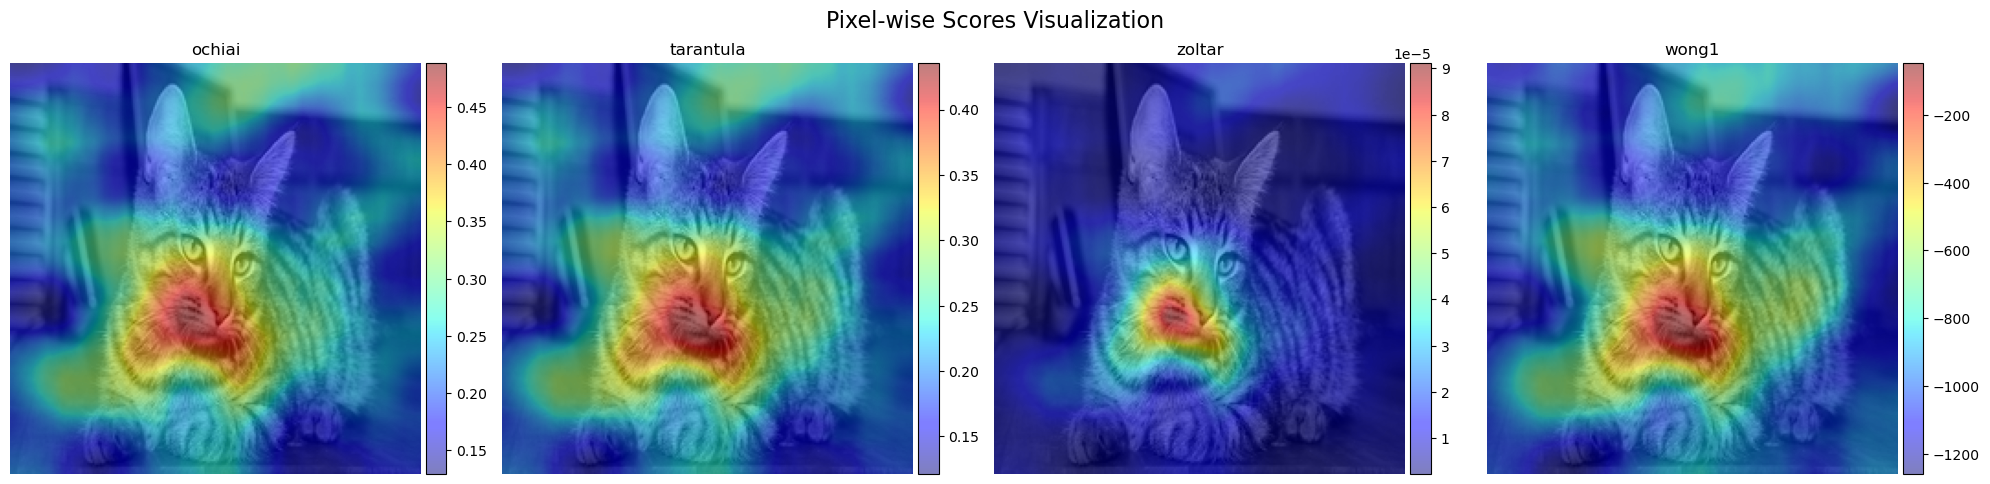

In [408]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import math

def calculate_relevance_scores(sampled_tensor, mask, N, confidence_scores, device='cuda'):
    sampled_tensor = sampled_tensor.to(device)
    _, _, H, W = sampled_tensor.shape
    
    all_indices = torch.arange(N, device=device)
    pass_indices = all_indices[all_indices % 2 != (N % 2)]
    fail_indices = all_indices[all_indices % 2 == (N % 2)]
    
    confidence_scores = torch.tensor(confidence_scores, dtype=torch.float32, device=device)
    good_scores, fail_scores = confidence_scores[::2], confidence_scores[1::2]
    
    m = math.ceil(N/2)
    goodscalar, badscalar = good_scores.view(m, 1, 1, 1), fail_scores.view(m, 1, 1, 1)
    
    executed_tensors = mask
    not_executed_tensors = 1 - mask
    
    e_pass_tensors = executed_tensors[pass_indices] * goodscalar
    e_fail_tensors = executed_tensors[fail_indices] * badscalar
    n_pass_tensors = not_executed_tensors[pass_indices] * goodscalar
    n_fail_tensors = not_executed_tensors[fail_indices] * badscalar
    
    return [tensor.sum(dim=0) for tensor in (e_pass_tensors, e_fail_tensors, n_pass_tensors, n_fail_tensors)]

def calculate_scores(Ep, Ef, Np, Nf):
    ochiai = Ef / torch.sqrt((Ef + Nf) * (Ef + Ep))
    tarantula = (Ef / (Ef + Nf)) / ((Ef / (Ef + Nf)) + (Ep / (Ep + Np)))
    zoltar = Ef / (Ef + Nf + Ep + (10000 * Nf * Ep / Ef))
    wong1 = Ef - Ep
    
    return {
        'ochiai': ochiai,
        'tarantula': tarantula,
        'zoltar': zoltar,
        'wong1': wong1
    }

def calculate_all_scores(img, masks, N, confidence_scores):
    Ep, Ef, Np, Nf = calculate_relevance_scores(img, masks, N, confidence_scores)
    scores = calculate_scores(Ep, Ef, Np, Nf)
    scores.update({'Ep': Ep, 'Ef': Ef, 'Np': Np, 'Nf': Nf})
    
    return scores, {k: v.detach().cpu().numpy().max() - v.detach().cpu().numpy() for k, v in scores.items()}

def create_pixel_dataset(pixel_scores, H, W):
    return [
        {
            'position': (i, j),
            **{k: v[0, i, j].item() for k, v in pixel_scores.items()}
        }
        for i in range(H) for j in range(W)
    ]

def visualize_pixel_scores(dataset, image_shape, original_image_array, scores_to_plot=None):
    scores = {k: np.zeros(image_shape) for k in dataset[0].keys() if k != 'position'}
    for pixel in dataset:
        i, j = pixel['position']
        for score_type, value in pixel.items():
            if score_type != 'position':
                scores[score_type][i, j] = value
    
    if scores_to_plot is None:
        scores_to_plot = ['ochiai', 'tarantula', 'zoltar', 'wong1']
    
    # Filter scores based on scores_to_plot
    scores = {k: v for k, v in scores.items() if k in scores_to_plot}
    
    num_plots = len(scores)
    rows = (num_plots + 3) // 4  # Calculate number of rows needed
    cols = min(4, num_plots)  # Use 4 columns or less if fewer plots
    
    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    fig.suptitle("Pixel-wise Scores Visualization", fontsize=16)
    cmap = plt.get_cmap('jet')
    
    axs = axs.flatten() if num_plots > 1 else [axs]  # Flatten axs if it's a 2D array
    
    for idx, (score_type, score_data) in enumerate(scores.items()):
        ax = axs[idx]
        im = ax.imshow(original_image_array, cmap='gray', alpha=1)
        im = ax.imshow(score_data, cmap=cmap, alpha=0.5)
        ax.set_title(score_type)
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    
    # Hide unused subplots
    for idx in range(num_plots, len(axs)):
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

'''
# This code by default will print all 4 measures, 
visualize_pixel_scores(dataset, image_shape, original_image_array)

# If you want to see only some of them, you can specify them in the scores_to_plot parameter
visualize_pixel_scores(dataset, image_shape, original_image_array, scores_to_plot=['ochiai', 'tarantula'])

# If interested in deeper analysis, you can inspect how the activation vector looks for this image:
visualize_pixel_scores(dataset, image_shape, original_image_array, scores_to_plot=['Ep', 'Ef', 'Np', 'Nf'])
'''

original_image = Image.open(img_path).resize((224, 224)).convert('L')
original_image_array = np.array(original_image)

pixel_scores, inverted_scores = calculate_all_scores(img, masks, N, confidence_scores)
dataset = create_pixel_dataset(pixel_scores, 224, 224)
visualize_pixel_scores(dataset, (224, 224), original_image_array)

In [409]:
import sys
rise_sfl_path = r"C:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\metrics-saliency-maps"  # Replace with the actual path to your RISE-SFL folder
sys.path.append(rise_sfl_path)
from tabulate import tabulate  

from saliency_maps_metrics.multi_step_metrics import Deletion, Insertion, compute_correlation, compute_auc_metric
from saliency_maps_metrics.data_replace import select_data_replace_method

deletion_metric = Deletion(data_replace_method="black", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)
insertion_metric = Insertion(data_replace_method="blur", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)


In [410]:
# Assuming the previous code is in place and has been executed, including:
# pixel_scores, inverted_scores = calculate_all_scores(img, masks, N, confidence_scores)
# Extract the specific saliency maps from the `pixel_scores` dictionary
zoltar_array = pixel_scores['zoltar'].detach().cpu().numpy()
tarantula_array = pixel_scores['tarantula'].detach().cpu().numpy()
wong1_array = pixel_scores['wong1'].detach().cpu().numpy()
ochiai_array = pixel_scores['ochiai'].detach().cpu().numpy()

# Create a dictionary of saliency maps
saliency_maps = {

    "Wong1": wong1_array[0],
    "Tarantula": tarantula_array[0],
    "Zoltar": zoltar_array[0],
    "Ochiai": ochiai_array[0]
}

# Create instances of Deletion and Insertion metrics
deletion_metric = Deletion(data_replace_method="black", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)
insertion_metric = Insertion(data_replace_method="blur", bound_max_step=True, batch_size=1, max_step_nb=14*14, cumulative=True)


In [411]:
results = []

def calculate_sparsity(saliency_map):
    max_value = np.max(saliency_map)
    mean_value = np.mean(saliency_map)
    return max_value / mean_value if mean_value != 0 else float('inf')
# Loop through each saliency map
for name, saliency_map in saliency_maps.items():
    # Convert saliency map to PyTorch tensor and add batch and channel dimensions
    saliency_map_tensor = torch.from_numpy(saliency_map).float().unsqueeze(0).unsqueeze(0)

    # Compute Deletion metrics
    deletion_result = deletion_metric(model, img, saliency_map_tensor, class_to_explain_list=[target_class])
    dauc_mean = deletion_result["dauc"]
    dc_mean = deletion_result["dc"]

    # Compute Insertion metrics
    insertion_result = insertion_metric(model, img, saliency_map_tensor, class_to_explain_list=[target_class])
    iauc_mean = insertion_result["iauc"]
    ic_mean = insertion_result["ic"]
    
    # Calculate sparsity
    sparsity = calculate_sparsity(saliency_map)

    # Store results
    results.append([name, dauc_mean, dc_mean, iauc_mean, ic_mean, sparsity])

# Create a table using tabulate
headers = ["Saliency Map", "DAUC", "DC", "IAUC", "IC", "Sparsity"]
table = tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f")

# Print the table
print(f"Metrics for target class: {target_class}")
print(table)

Metrics for target class: 282
+----------------+--------+--------+--------+--------+------------+
| Saliency Map   |   DAUC |     DC |   IAUC |     IC |   Sparsity |
+================+========+========+========+========+============+
| Wong1          | 0.0397 | 0.5001 | 0.5251 | 0.1630 |     0.0534 |
+----------------+--------+--------+--------+--------+------------+
| Tarantula      | 0.0408 | 0.4855 | 0.4947 | 0.1594 |     1.9321 |
+----------------+--------+--------+--------+--------+------------+
| Zoltar         | 0.0437 | 0.5453 | 0.4908 | 0.1438 |     6.7806 |
+----------------+--------+--------+--------+--------+------------+
| Ochiai         | 0.0436 | 0.5066 | 0.4909 | 0.1411 |     1.9784 |
+----------------+--------+--------+--------+--------+------------+
